# Bkg investigations

**Goal:** I futzed around a bit with some $\kappa_\lambda$ = 10 plots and came up with an *idea* for how to recover some signal efficienty for the low mass $\kappa_\lambda = 10$ sample.

I'm proposing a *new* massplane to target the lower $m_{hh}$ region, so now I want to see the impact for the background.

Sean has some *new* reweightings with the shifted SR, but I'm trying to see if there's anything we can gain w/ a dedicated low-mass-attack strategy.

However, since the rws that Sean saves are *only* saving the SR,VR, and CR, I'll need to load in the full massplane rn lol.

In [1]:
import os
os.sys.path+= ['../RRevolution/code/','../code/','../PAG-opt/']
from analysis import getXhh,getRegions
from plots import draw_SR, draw_VR, draw_CR
from utils import mcToYr
from eventDisplays import rainbow_text

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
yr=17

In [3]:
fname = f'../data/RR/nom_trigs_unblind/data{yr}_min_dR_VEC_sr_124_117.root'

tname='everything'
cut_str = '~ pass_vbf_sel'
#cut_str = '(dEta_hh < 1.5) & (~ pass_vbf_sel)'

#text += r"min_dR, pre-$X_{wt}$, VBF veto"
#figDir += '/pre_Xwt'

Ok - first let's just try to figure out the syntax w/ 1000 events.

In [17]:
cols = ['pass_vbf_sel', 'ntag', #'truth_mhh', 'njets', 'kinematic_region',
        #'bucket_passed', 'cos_theta_star', 'm_hh_cor', 'trig_bucket',
        'm_hh', 'X_wt_tag', #'pt_hh','dEta_hh',
        'm_h1','m_h2',
        'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 
        'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 
        'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1',
        'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2']#, 
        #'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2']

In [18]:
with uproot.open(f'{fname}:{tname}') as t:
    dfi = t.arrays(cols,cut=cut_str,entry_stop=1000000,library='pd')

In [19]:
# 
#     df_4b = t.arrays(cols,cut='(ntag>=4) & (m_hh<350) & (~ pass_vbf_sel)',library='pd')

In [20]:
x1,y1 = 124,117

In [21]:
plt.hist2d(*dfi.loc[dfi.ntag==2,['m_h1','m_h2']].values.T,
           25,[(50,200),(50,200)],cmap='YlGnBu')

plt.colorbar()
plt.xlabel('m_h1')
plt.ylabel('m_h2')

for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')

plt.title('2b everything')
plt.show()

Ok, sweeto neato! Low stats, but seems reaonsalbe.

**Plan:** 
- Reconstruct the 4-vectors for all possible pairings
- Sort by higgs pT
- Find the 2 pairs that have the smallest dRjj_1 difference
- Add these two HCs up
- Draw the new massplane
- Apply the analysis cuts
- Get a comparison of the two SRs

In [23]:
import awkward as ak
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

In [24]:
j4 = ak.zip(
    {
        "pt":  dfi[[f'pT_h{i}_j{j}'  for i,j in product([1,2],[1,2])]].values,
        "eta": dfi[[f'eta_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,
        "phi": dfi[[f'phi_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,
        "energy":   dfi[[f'E_h{i}_j{j}'   for i,j in product([1,2],[1,2])]].values,
    },
    with_name="PtEtaPhiELorentzVector",
)

ok, so *next* let's find the two pairs with the closest dRjjs!

In [26]:
for pi,i11,i12,i21,i22 in zip(range(3),
                              [0,0,0],[1,2,3],
                              [2,1,1],[3,3,2]):

    h1 = j4[:,i11] + j4[:,i12]
    h2 = j4[:,i21] + j4[:,i22]
    
    dR1 = j4[:,i11].delta_r(j4[:,i12])
    dR2 = j4[:,i21].delta_r(j4[:,i22])
    dfi[f'pair{pi}_dRjj_h1'] = np.where(h1.pt > h2.pt, dR1, dR2)
    dfi[f'pair{pi}_dRjj_h2'] = np.where(h1.pt < h2.pt, dR1, dR2)
    
    # Save the 4-vector info 
    dfi[f'pair{pi}_deta_hh'] = abs(h1.eta - h2.eta)
    
    
    dfi[f'pair{pi}_m_h1'] = np.where(h1.pt > h2.pt, h1.mass, h2.mass)
    dfi[f'pair{pi}_m_h2'] = np.where(h1.pt < h2.pt, h1.mass, h2.mass)
   

Next: form all possible combinations

In [27]:
dfi[f'comb0_dR1diff'] = np.abs(dfi[f'pair1_dRjj_h1'] - dfi[f'pair2_dRjj_h1'])
dfi[f'comb1_dR1diff'] = np.abs(dfi[f'pair0_dRjj_h1'] - dfi[f'pair2_dRjj_h1'])
dfi[f'comb2_dR1diff'] = np.abs(dfi[f'pair0_dRjj_h1'] - dfi[f'pair1_dRjj_h1'])

In [28]:
comb_i = np.argmin(dfi[[f'comb{i}_dR1diff' for i in range(3)]].values,axis=1)

In [29]:
np.histogram(comb_i,3,(-.5,2.5),density=True)[0]

array([0.67254135, 0.16105367, 0.16640498])

In [30]:
np.histogram(comb_i[dfi.m_hh < 350],3,(-.5,2.5),density=True)[0]

array([0.69387619, 0.14293327, 0.16319054])

Sweet, so 70% of the time, this chooses the combination that *doesn't* include min_dR.

**Next:** We *do* need to decide if we want to just use the avg of the deta's and m_h1, m_h2 or *add* up the 4 vectors.

In [31]:
mhh_cutoff = 350

mi = (dfi.ntag==2)&(dfi.m_hh<350)

for c in ['m_h1','m_h2']:
    
    plt.figure()
    for i in range(3):
        plt.hist(dfi.loc[mi,f'pair{i}_{c}'],25,(50,200),histtype='step',lw=4,label=f'pair{i}')
    plt.xlabel(f'{c} [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend()
    
    ylim = plt.ylim()
    plt.plot([125]*2,ylim,'k--')
    plt.ylim(ylim)

    plt.title(f'2b 20{yr} data, m_hh < {mhh_cutoff} GeV')

But ok, this is already looking approximately like I was expecting.

In [32]:
for i, p1,p2 in zip(range(3),[1,0,0],[2,2,1]):
    
    m = comb_i==i
    for v in ['deta_hh','m_h1','m_h2']:
        dfi.loc[m,f'{v}_avg'] = 0.5*(dfi.loc[m,f'pair{p1}_{v}']+dfi.loc[m,f'pair{p2}_{v}'])

In [33]:
dfi['Xhh_avg'] = getXhh(*dfi[['m_h1_avg','m_h2_avg']].values.T,x1,y1)

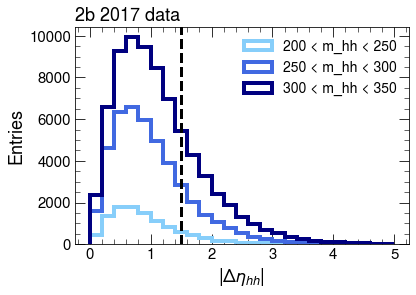

In [34]:
mbins = [200,250,300,350]
for mmin,mmax,c in zip(mbins[:-1],mbins[1:],['lightskyblue','royalblue','navy']):
    mi = (dfi.ntag==2) & (dfi.m_hh > mmin) & (dfi.m_hh < mmax)
    plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
             histtype='step',lw=4,color=c,label=f'{mmin} < m_hh < {mmax}')

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
plt.ylabel('Entries',fontsize=18)
plt.legend()
plt.title(f'2b 20{yr} data',loc='left')

ylim = plt.ylim()
plt.plot([1.5]*2, ylim,'k--')
plt.ylim(ylim)

plt.show()

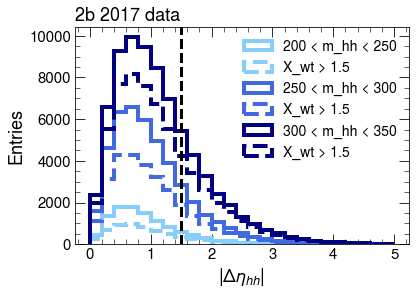

In [35]:
mbins = [200,250,300,350]
for mmin,mmax,c in zip(mbins[:-1],mbins[1:],['lightskyblue','royalblue','navy']):
    mi = (dfi.ntag==2) & (dfi.m_hh > mmin) & (dfi.m_hh < mmax)
    plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
             histtype='step',lw=4,color=c,label=f'{mmin} < m_hh < {mmax}')
    
    plt.hist(dfi.loc[mi & (dfi.X_wt_tag > 1.5),'deta_hh_avg'],25,(0,5),
             histtype='step',lw=4,ls='--',color=c,label=f'X_wt > 1.5')
    

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
plt.ylabel('Entries',fontsize=18)
plt.legend()
plt.title(f'2b 20{yr} data',loc='left')

ylim = plt.ylim()
plt.plot([1.5]*2, ylim,'k--')
plt.ylim(ylim)

plt.show()

Yeah, X_wt has a *big* impact on this category... but this really isn't news lol.

Ok, so I really need to break this down by the CR and VR, but I *don't* think I have the stats to do this rn (full disclosure).

In [36]:
x1,y1

(124, 117)

In [37]:
# This would just re-load in the nominal regions b/c these NNTs w/ a shifted SR
#getRegions(dfi,x1,y1)

In [38]:
getRegions(dfi,x1,y1,'m_h1_avg','m_h2_avg',kr='kr_avg')

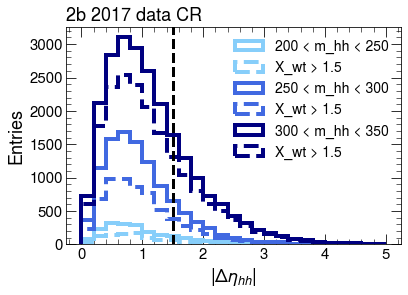

In [39]:
for i,reg in enumerate(['SR','VR','CR']):

    plt.figure()

    for mmin,mmax,c in zip(mbins[:-1],mbins[1:],['lightskyblue','royalblue','navy']):
        mi = (dfi.ntag==2) & (dfi.m_hh > mmin) & (dfi.m_hh < mmax) & (dfi.kr_avg==i)
        plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c,label=f'{mmin} < m_hh < {mmax}')

        plt.hist(dfi.loc[mi & (dfi.X_wt_tag > 1.5),'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,ls='--',color=c,label=f'X_wt > 1.5')


    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Entries',fontsize=18)
    plt.legend()
    plt.title(f'2b 20{yr} data {reg}',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

plt.show()

Ok, not surprising, but X_wt is having a *huge* impact rn.

(If I'm trying to opt for low mass, could I not include X_wt?)

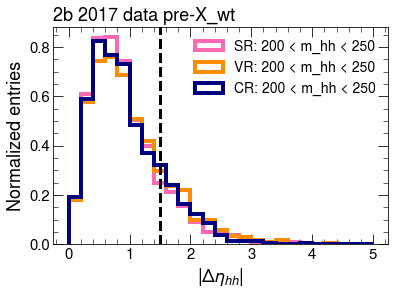

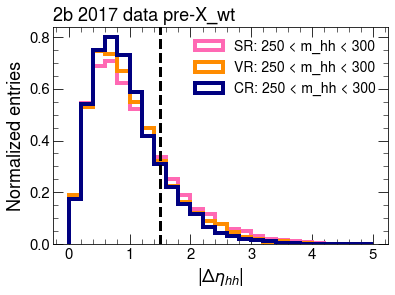

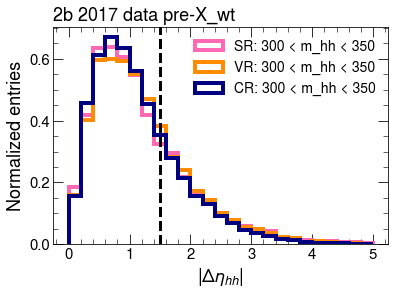

In [45]:
for mmin,mmax in zip(mbins[:-1],mbins[1:]):#,['lightskyblue','royalblue','navy']):
    
    plt.figure()
    for i,reg,c in zip(range(3),['SR','VR','CR'],['hotpink','darkorange','navy']):
        
        mi = (dfi.ntag==2) & (dfi.m_hh > mmin) & (dfi.m_hh < mmax) & (dfi.kr_avg==i)
        plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c,
                 label=f'{reg}: {mmin} < m_hh < {mmax}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized entries',fontsize=18)
    plt.legend()
    plt.title(f'2b 20{yr} data pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

plt.show()

Hmmmmm - very interesting. So when I make these $\Delta \eta_{hh}$ bins, this *consistency* cross the regions goes away.

Since the behavior of the high $\Delta \eta_{hh}$ tails was opposit for the 200-250 GeV and 250-300 GeV bins, I decided to try *combining* t

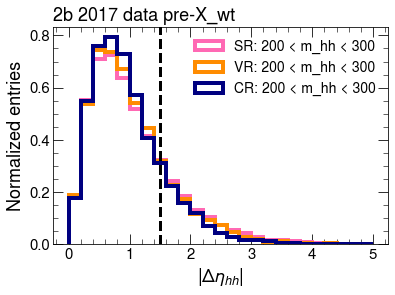

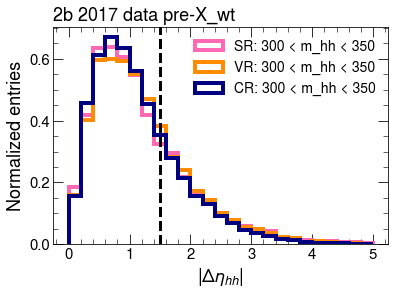

In [46]:
for mmin,mmax in zip([200,300],[300,350]):#,['lightskyblue','royalblue','navy']):
    
    plt.figure()
    for i,reg,c in zip(range(3),['SR','VR','CR'],['hotpink','darkorange','navy']):
        
        mi = (dfi.ntag==2) & (dfi.m_hh > mmin) & (dfi.m_hh < mmax) & (dfi.kr_avg==i)
        plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c,
                 label=f'{reg}: {mmin} < m_hh < {mmax}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized entries',fontsize=18)
    plt.legend()
    plt.title(f'2b 20{yr} data pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

plt.show()

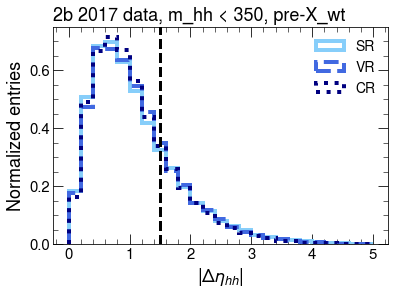

In [41]:
#for mmin,mmax,c in zip(mbins[:-1],mbins[1:],):

for i,reg,ls,c in zip(range(3),['SR','VR','CR'],['-','--','dotted'],['lightskyblue','royalblue','navy']):

        mi = (dfi.ntag==2) & (dfi.m_hh < mhh_cutoff) & (dfi.kr_avg==i)
        plt.hist(dfi.loc[mi,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c,ls=ls,
                 label=reg,density=True)

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
plt.ylabel('Normalized entries',fontsize=18)
plt.legend()
plt.title(f'2b 20{yr} data, m_hh < {mhh_cutoff}, pre-X_wt',loc='left')

ylim = plt.ylim()
plt.plot([1.5]*2, ylim,'k--')
plt.ylim(ylim)

plt.show()

**Message:** Taking the difference in the template predictions b/w the VR and CR is *not* a good estimate of the error in the SR.